# UC SD Micromasters - Python for Data Science
# Craigslist Used Cars Dataset
## Price Prediction with Decision Tree Regressor 


In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

## Import and read dataset

First, look at downloaded file from https://www.kaggle.com/austinreese/craigslist-carstrucks-data/download.

In [2]:
from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

craigslist-carstrucks-data.zip
vehicles.csv



Unzip the file and extract into the data folder.

In [ ]:
# how to from https://www.kaggle.com/mchirico/how-to-read-datasets
import zipfile
Dataset = "craigslist-carstrucks-data"

with zipfile.ZipFile("./data/"+Dataset+".zip","r") as z:
    z.extractall("./data")

Import data as pandas dataframe.

In [3]:
cars_raw = pd.read_csv("./data/vehicles.csv")

In [4]:
# dataframe shape
print("Number of rows:",cars_raw.shape[0])
print()
print("Number of columns",cars_raw.shape[1])

Number of rows: 539759

Number of columns 25


## Preliminary Data Cleaning

Remove unnecessary columns and null values. Let's look at the proportion of non-null values as percent of total number of rows. This will give us an idea of which variables contain actual data vs those that are mostly `NULL`

In [5]:
no_null_prc = (cars_raw.count()/len(cars_raw)).round(2)*100
no_null_prc

id              100.0
url             100.0
region          100.0
region_url      100.0
price           100.0
year            100.0
manufacturer     96.0
model            99.0
condition        56.0
cylinders        60.0
fuel             99.0
odometer         82.0
title_status     99.0
transmission     99.0
vin              58.0
drive            71.0
size             31.0
type             73.0
paint_color      68.0
image_url       100.0
description     100.0
county            0.0
state           100.0
lat              98.0
long             98.0
dtype: float64

Select columns of interest that have greater than 80% of actual data.

In [60]:
cols_to_use = list(no_null_prc[no_null_prc>=70].index)
cols_to_use

['id',
 'url',
 'region',
 'region_url',
 'price',
 'year',
 'manufacturer',
 'model',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'type',
 'image_url',
 'description',
 'state',
 'lat',
 'long']

Remove the first 4 columns: these columns only contain the id and other url information. We also remove description, image_url, and location information.

In [63]:
cols_not_needed = list(cars_raw.columns[0:4])
cols_not_needed.extend(['description','image_url','state','lat','long','manufacturer','model'])
cols_not_needed

['id',
 'url',
 'region',
 'region_url',
 'description',
 'image_url',
 'state',
 'lat',
 'long',
 'manufacturer',
 'model']

Lastly, we remove any `na` values select our features of interest

In [67]:
cars = cars_raw[[name for name in cols_to_use if name not in cols_not_needed]]
cars = cars.dropna()
cars.sample(10)

,price,year,fuel,odometer,title_status,transmission,drive,type
41383,0,2011.0,other,126038.0,clean,automatic,4wd,other
353463,13900,2018.0,gas,12300.0,clean,automatic,fwd,sedan
274167,16000,2017.0,gas,33218.0,clean,automatic,fwd,other
449118,24999,2013.0,gas,91182.0,clean,automatic,4wd,truck
177440,2200,2007.0,gas,144739.0,clean,manual,fwd,hatchback
221206,6995,2008.0,gas,144843.0,clean,automatic,fwd,mini-van
380882,4950,2002.0,other,172542.0,clean,automatic,4wd,truck
202928,12900,2016.0,gas,26000.0,rebuilt,automatic,fwd,SUV
175993,38849,2017.0,gas,25777.0,clean,automatic,4wd,SUV
399687,5500,1997.0,gas,145000.0,clean,automatic,4wd,SUV


In [68]:
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 302911

Number of columns 8


### Description of the variables:

Here is a breakdown of the variables and their types. In our analysis, `price` will be the predicted variables.

Categorical variables:
- drive
- type
- fuel
- title_status
- transmission
- state

Numerical variables:
- price
- year
- odometer

Date variables:
- year

## Preliminary data exploration and further cleaning

We will now explore the data and determine what further cleaning needs to be done. First, lets look at the distribution of the numeric variables, here is a summary of the median data : 

- Median price is \$10,749 while the max value is $4.2 billion!
- Median odometer reading is 93500 mi.
- Median year is 2012

Here are some more additiona statistics.

In [69]:
cars.describe(percentiles=[0.05,0.1,0.5,0.9,0.95]).transpose()

,count,mean,std,min,5%,10%,50%,90%,95%,max
price,302911.0,191389.370987,2.333448e+07,0.0,0.0,900.0,10990.0,28000.0,34900.0,4.198287e+09
year,302911.0,2010.844987,7.058727e+00,1900.0,2000.0,2003.0,2012.0,2017.0,2018.0,2.021000e+03
odometer,302911.0,100539.526382,1.132707e+05,0.0,12933.0,23581.0,93674.0,179000.0,205000.0,1.000000e+07


### Price and Odometer

Remove vehicles with prices and odometer readings that are slightly more than the 90% percentile and less than the 1% percentile. This will get rid of extreme outliers. We will also remove `year` values equal to zero. 

In [70]:
cars = cars[(cars.price<=30000) & 
              (cars.price>1000) & 
              (cars.odometer<=180000) &  
              (cars.odometer>=2000) & 
              (cars.year > 0)]

# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 217652

Number of columns 8


Let's look at a plot of a joint histogram using exagonal bins of the price with odometer reading: notice the downward non-linear nature of of the data.

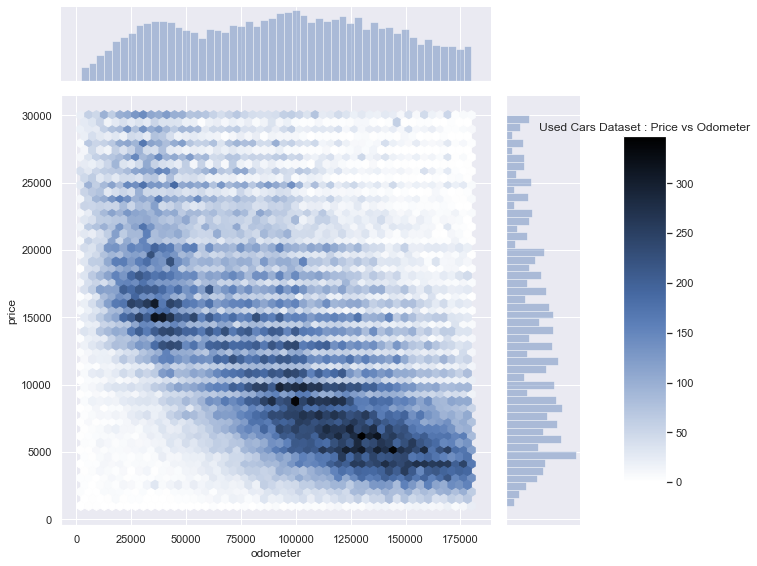

In [71]:
# how to add legend from https://stackoverflow.com/questions/29096632/getting-legend-in-seaborn-jointplot/29909033
hexplot = sns.jointplot("odometer", "price", data=cars,size=12,kind = "hex");
cbar_ax = hexplot.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
plt.colorbar(cax=cbar_ax)
plt.title('Used Cars Dataset : Price vs Odometer')
plt.show()

### Transmission

A large majority of values in transmission are laballed as  "other":

In [72]:
cars.transmission.value_counts()

automatic    192228
other         13120
manual        12304
Name: transmission, dtype: int64

We'll assume transmission labeled "other" is automatic:

In [73]:
cars['transmission'] = np.where(cars.transmission == "other","automatic",cars.transmission)

Now let's look at the boxplot of transmission type vs price. Notice that vehicles with an automatic transmission tend to be at slightly higher price:

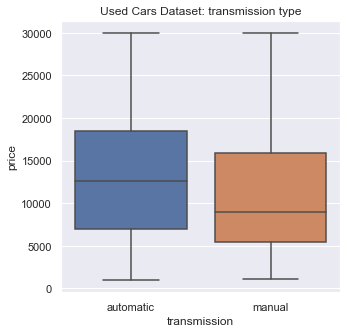

In [74]:
plt.figure(figsize=(5,5))
sns.boxplot(x='transmission',y='price',data=cars).set_title('Used Cars Dataset: transmission type');

### Title Status

A very small number of listings of `title_status` values are either labeled "missing" or "parts only". So we'll remove those variables from the dataset.

In [75]:
cars.title_status.value_counts()

clean         207502
rebuilt         6372
salvage         2217
lien            1455
missing           85
parts only        21
Name: title_status, dtype: int64

In [76]:
# remove 'missing' and 'parts only'
keep = ['clean','rebuilt','salvage','lien']
cars = cars[cars['title_status'].isin(keep)]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 217546

Number of columns 8


Now let's look a the boxplot of title status vs price. Interestingly, vehicles with a lien tend to be higher priced. This could be because those vehicles typically are being sold to pay off creditors (banks, dealerships, etc.)

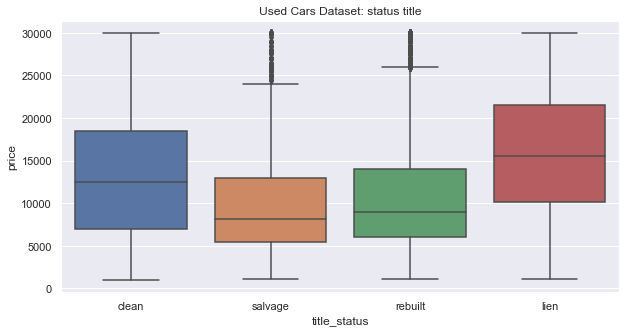

In [77]:
plt.figure(figsize=(10,5))
sns.boxplot(x='title_status',y='price',data=cars).set_title('Used Cars Dataset: status title');

### Fuel Type

Let's take a look at the distribution of prices by fuel type: notice that diesel-powered vehicles tend to be more expensive, while hybrid-types are the cheapest.

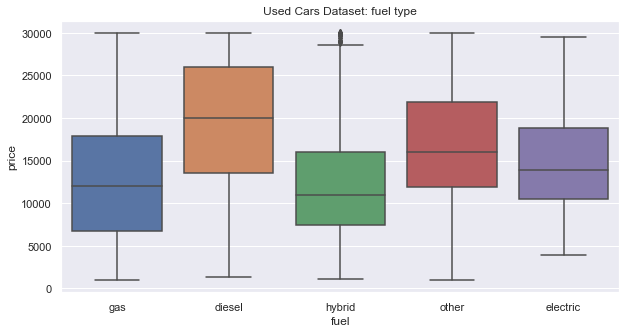

In [78]:
plt.figure(figsize=(10,5))
sns.boxplot(x='fuel',y='price',data=cars).set_title('Used Cars Dataset: fuel type');

Vehicles with fuel type as  "other" can be removed from the analysis since it would be difficult to identify the fuel to for those:

In [79]:
cars.fuel.value_counts()

gas         199815
diesel        9689
other         5315
hybrid        2268
electric       459
Name: fuel, dtype: int64

In [80]:
# remove fuel type "other"
cars = cars[~cars['fuel'].isin(['other'])]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 212231

Number of columns 8


### Year

Lets see the number of vehicles grouped by year on a line plot: notice that most vehicles listings are for vehicles of years between the late 90's and early 2020.

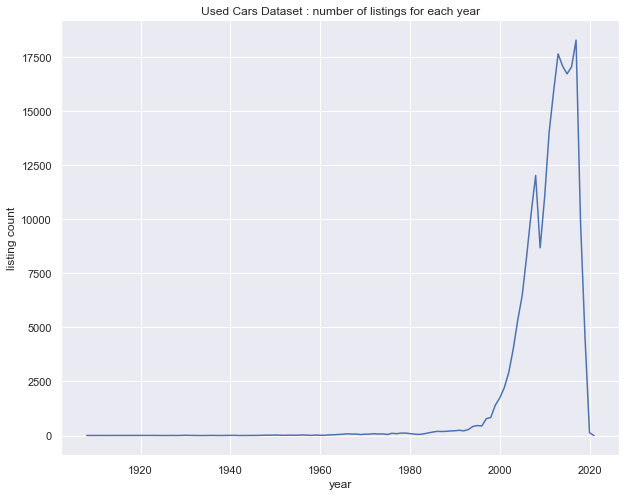

In [81]:
grouped_by_year = cars.groupby('year').count().reset_index()
plt.figure(figsize=(10,8))
ax = sns.lineplot(x='year',y='price',data=grouped_by_year);
ax.set(ylabel="listing count",title='Used Cars Dataset : number of listings for each year');

For this analysis we'll look at listings between 1999 and 2019:

In [82]:
cars = cars[(cars.year>=1999) & (cars.year<=2019)]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 205263

Number of columns 8


## Type

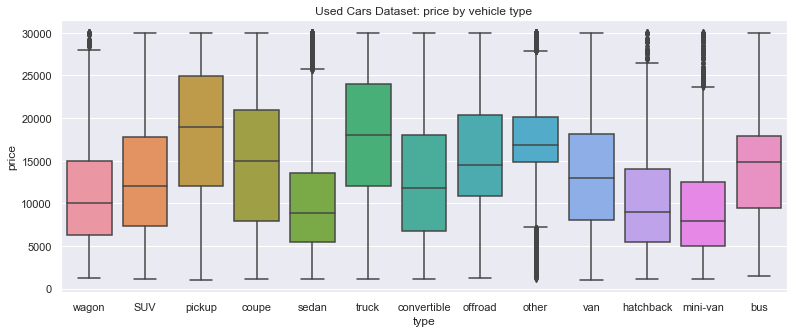

In [84]:
plt.figure(figsize=(13,5))
sns.boxplot(x='type',y='price',data=cars).set_title('Used Cars Dataset: price by vehicle type');

In [86]:
cars.type.value_counts()

sedan          57573
SUV            52793
truck          22989
pickup         22393
coupe          11464
hatchback       8727
other           7896
wagon           7390
van             5385
convertible     4342
mini-van        3828
offroad          310
bus              173
Name: type, dtype: int64

We can remove instances that do not occur very often (type `offroad` and `bus`), as well as `other`. Can also merge the `pickup` and `truck` categories into one : `pickup`. 

In [87]:
# remove type "bus","offroad","other"
cars = cars[~cars['type'].isin(['other','offroad','bus'])]

In [89]:
# change "truck" to "pickup"
cars['type'] = np.where(cars.type == "truck","pickup",cars.type)

In [90]:
cars.type.value_counts()

sedan          57573
SUV            52793
pickup         45382
coupe          11464
hatchback       8727
wagon           7390
van             5385
convertible     4342
mini-van        3828
Name: type, dtype: int64

## Drive

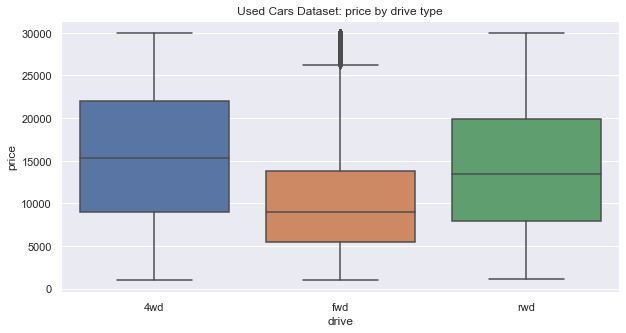

In [92]:
plt.figure(figsize=(10,5))
sns.boxplot(x='drive',y='price',data=cars).set_title('Used Cars Dataset: price by drive type');

In [94]:
cars.drive.value_counts()

4wd    83753
fwd    79820
rwd    33311
Name: drive, dtype: int64

In [95]:
cars.sample(10)

,price,year,fuel,odometer,title_status,transmission,drive,type
267328,8950,2011.0,gas,121333.0,clean,automatic,rwd,pickup
525630,14900,2016.0,gas,30595.0,clean,automatic,fwd,sedan
162815,13900,2014.0,gas,77287.0,clean,automatic,rwd,coupe
148284,24683,2017.0,gas,9123.0,clean,automatic,fwd,convertible
36878,19500,2013.0,gas,84150.0,clean,automatic,4wd,pickup
136217,17990,2017.0,gas,17050.0,clean,manual,rwd,convertible
452877,15571,2018.0,gas,37010.0,clean,automatic,fwd,sedan
11459,10995,2008.0,gas,179176.0,clean,automatic,4wd,SUV
6790,10499,2013.0,gas,83600.0,clean,manual,fwd,SUV
154638,21999,2006.0,diesel,110771.0,clean,automatic,4wd,pickup


## Categorical Variable Encoding

## Decision Tree Regression

We are now ready to predict the `price` of a vehicle using a Decision Tree Regression. First we identify the predicted variable.

### Perform Training and Testing Split

In [51]:
# predicted variable
y = cars[['price']].copy()
y.head()

,price
0,10299
5,12995
6,10995
7,8995
10,7995


In [52]:
# features
X = cars.iloc[:,1:].copy()
X.head()

,year,manufacturer,model,fuel,odometer,title_status,transmission
0,2012.0,acura,tl,gas,90186.0,clean,automatic
5,2015.0,kia,sportage,gas,85127.0,clean,automatic
6,2014.0,chevrolet,traverse,gas,112383.0,clean,automatic
7,2011.0,bmw,528i,gas,124446.0,clean,automatic
10,2008.0,nissan,frontier,gas,162214.0,clean,automatic


In [53]:
# inputs X and y, 33% of data as test, seed is set to 324 (for repeatibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

In [56]:
# quick look at the reult types and first few rows of the features
print(type(X_train))
print(type(X_test))
print(type(y_test))
print()
print(X_train.head())
print()
print(y_train.describe())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>

          year manufacturer   model fuel  odometer title_status transmission
534776  2006.0      pontiac    vibe  gas  120954.0        clean    automatic
20137   2004.0         ford  ranger  gas  169479.0        clean       manual
257803  2008.0       toyota   yaris  gas  148000.0        clean    automatic
460354  2017.0       nissan  maxima  gas   34473.0        clean    automatic
485885  2017.0       toyota   camry  gas   78053.0        clean    automatic

               price
count  121095.000000
mean    12864.794847
std      7214.711613
min      1010.000000
25%      6900.000000
50%     11900.000000
75%     17900.000000
max     30000.000000


In [59]:
# fit regression model
estimator = DecisionTreeRegressor(max_depth=5,
                                  min_samples_leaf=50,
                                  min_samples_split=100)

estimator.fit(X_train,y_train)

ValueError: could not convert string to float: 'pontiac'